## Classification Problem
Testing the Knn, logistic regression, and perceptron algorithms on the "Rain in Australia" dataset from the Kaggle website using different metrics https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package.

### Loading the data:

In [8]:
import numpy as np
np.random.seed(12345) # So that if I use it and forget to write the seed

In [9]:
# Load the dataset
import pandas as pd
rain_path = 'weatherAUS.csv'
rain_df = pd.read_csv(rain_path)

### Basic EDA and Basic Feature Engineering:

In [10]:
# See the columns in the dataset as well as its Dtypes
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [11]:
# Counting the missing values
rain_df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [12]:
# Counting the unique values
rain_df.nunique()

Date             3436
Location           49
MinTemp           389
MaxTemp           505
Rainfall          681
Evaporation       358
Sunshine          145
WindGustDir        16
WindGustSpeed      67
WindDir9am         16
WindDir3pm         16
WindSpeed9am       43
WindSpeed3pm       44
Humidity9am       101
Humidity3pm       101
Pressure9am       546
Pressure3pm       549
Cloud9am           10
Cloud3pm           10
Temp9am           441
Temp3pm           502
RainToday           2
RainTomorrow        2
dtype: int64

In [13]:
# Focusing on the target value
display(rain_df['RainTomorrow'].isnull().sum())
display(rain_df['RainTomorrow'].nunique())
display(rain_df['RainTomorrow'].unique())
display(rain_df['RainTomorrow'].value_counts())
display(rain_df['RainTomorrow'].value_counts())
display('-----------------------------------------------')

# Removing the nan values from the target column since we cant test or train on those data points
rain_df = rain_df[rain_df['RainTomorrow'].notnull()]
display(rain_df['RainTomorrow'].isnull().sum())
display(rain_df['RainTomorrow'].nunique())
display(rain_df['RainTomorrow'].unique())
display(rain_df['RainTomorrow'].value_counts())
display(rain_df['RainTomorrow'].value_counts())

3267

2

array(['No', 'Yes', nan], dtype=object)

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

'-----------------------------------------------'

0

2

array(['No', 'Yes'], dtype=object)

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

In [14]:
# See the percentage of the missing values in the dataset
rain_df.isnull().sum()/len(rain_df)

Date             0.000000
Location         0.000000
MinTemp          0.004480
MaxTemp          0.002265
Rainfall         0.009888
Evaporation      0.427890
Sunshine         0.476929
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir9am       0.070418
WindDir3pm       0.026570
WindSpeed9am     0.009480
WindSpeed3pm     0.018496
Humidity9am      0.012476
Humidity3pm      0.025388
Pressure9am      0.098556
Pressure3pm      0.098324
Cloud9am         0.377353
Cloud3pm         0.401525
Temp9am          0.006358
Temp3pm          0.019171
RainToday        0.009888
RainTomorrow     0.000000
dtype: float64

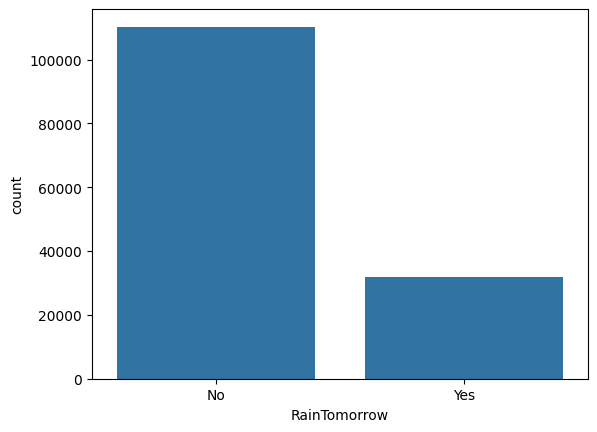

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# To see the distribution of the data in the label column
sns.countplot(x='RainTomorrow', data=rain_df)
plt.show()

In [10]:
# Drop the columns with the percentage missing value of above 40%(Sunshine, Evaporation)
rain_df = rain_df.drop(['Sunshine', 'Evaporation'], axis=1)
rain_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday', 'RainTomorrow'],
      dtype='object')

In [11]:
# Define numerical and categorical features for imputing
numerical_features = rain_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = rain_df.select_dtypes(include=['object']).drop(['RainTomorrow', 'Date'],
                                                                   axis=1).columns # Since Date is not same as the others

In [12]:
# Map 'Yes' and 'No' to 1 and 0 for roc-auc
rain_df['RainTomorrow'] = rain_df['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Median since statistacally better
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Same reason as the Median
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

### Basic CV:

In [14]:
# Folding properties
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, random_state=12345, shuffle=True)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict

def evaluate_model(model, X, y, cv):
    # Get model predictions using cross-validation for both class labels and probabilities (for ROC AUC)
    y_pred = cross_val_predict(model, X, y, cv=cv, method='predict')
    y_probs = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]  # Get probabilities for the positive class

    # Compute metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_probs)  # Use probabilities for ROC AUC
    
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC AUC: {roc_auc}")

    return accuracy, precision, recall, f1, roc_auc


In [18]:
# Loading the Classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV

accuracy, precision, recall, f1, roc_auc = {}, {}, {}, {}, {}

### Training and Evaluating Each Model:

In [19]:
# KNN Evaluation
knn_model = make_pipeline(preprocessor, KNeighborsClassifier())
accuracy['knn'], precision['knn'], recall['knn'], f1['knn'], roc_auc['knn'] = evaluate_model(knn_model, 
                                                                                             rain_df.drop('RainTomorrow', axis=1),
                                                                                             rain_df['RainTomorrow'], kf)

Accuracy: 0.8362999585070995, Precision: 0.6942186088527552, Recall: 0.4821658248894187, F1 Score: 0.5690801044115741, ROC AUC: 0.8215568318244646


In [32]:
# Perceptron Evaluation
# Wrap Perceptron with calibration since perceptron algorithm doesn't inherently support predict_proba
calibrated_perc = make_pipeline(preprocessor, CalibratedClassifierCV(Perceptron(), method='sigmoid', cv=5))
accuracy['per'], precision['per'], recall['per'], f1['per'], roc_auc['per'] = evaluate_model(calibrated_perc,
                                                                                             rain_df.drop('RainTomorrow', axis=1),
                                                                                             rain_df['RainTomorrow'], kf)

Accuracy: 0.7936325979478596, Precision: 0.8876645240281604, Recall: 0.09097468394139975, F1 Score: 0.1650352834054177, ROC AUC: 0.8423225273552538


In [21]:
# Logistic Regression Evaluation
log_reg_model = make_pipeline(preprocessor, LogisticRegression())
accuracy['logres'], precision['logres'], recall['logres'], f1['logres'], roc_auc['logres'] = evaluate_model(log_reg_model,
                                                                                                            rain_df.drop('RainTomorrow', axis=1),
                                                                                                            rain_df['RainTomorrow'], kf)

Accuracy: 0.8470810799406441, Precision: 0.7286429893045715, Recall: 0.5065093954889105, F1 Score: 0.597601598934044, ROC AUC: 0.8675259255998229


# Model Evaluations
**K-Nearest Neighbours (KNN)** showed an accuracy of 83.63%, demonstrating its high degree of consistency in properly predicting rainfall. But given its precision of 69.42%, it appears to be relatively, if not extremely, dependable when predicting the presence of rain. The model's F1 score of 56.90%, which shows a noticeable disparity between precision and recall, is consistent with its recall of 48.21%, which indicates a decent ability to detect the actual rainy days. An 82.16% ROC AUC score shows a good ability to distinguish between the classes over a range of criteria.

**Perceptron** showed an exceptional precision of 88.76% and an accuracy of 79.36%, indicating that its positive predictions are highly likely to be accurate. On the other hand, this model's very poor recall of 9.09% suggests that it misses a sizable portion of wet days. The F1 score of 16.50%, which shows a significant difference between recall and precision, significantly reflects this. However, the 84.23% ROC AUC score is very high, suggesting a good capacity to discriminate across classes at various thresholds.

With an accuracy of 84.71%, **Logistic Regression** emerged as the most dependable model for rainfall prediction. Its recall of 50.65%, the highest of the models, balances its lower precision of 72.86% compared to the Perceptron, suggesting a higher overall ability to identify rainy days. With a maximum score of 59.76%, the F1 score indicates a more equitable trade-off between recall and precision. The maximum ROC AUC score of 86.76% confirms the robustness of Logistic Regression in class discrimination.

# Discussion
Based on the F1 score, the **Logistic Regression** model is the most successful, showing the highest accuracy and the best combination of precision and recall. Its strong performance across various thresholds is further attested to by its high ROC AUC score. For binary classification issues with probabilistic outcomes, like weather prediction, where the probability of an event is just as important as the event itself, this model is ideally suited.

**KNN** had a lower recall, which limited its performance. KNN's limitations in this scenario may be explained by the fact that its performance is strongly influenced by the local structure of the data and that it may become less effective in datasets with complex distributions or irrelevant features.

**Perceptron** shows good precision, but its low recall is a major letdown. This discrepancy implies that although the Perceptron can be very certain about the situations it recognises as rain, it misses most wet days. The intricate patterns found in weather data, which are not linearly separable, may be difficult for Perceptron to handle due to its linear structure.

The distribution and complexity of the data are important factors in choosing the optimal model. Logistic regression performs better in complicated and imbalanced datasets, which are typical of real-world phenomena like weather patterns. This is because it can handle non-linear correlations and produce probability estimates.

Though each model has advantages of its own, Logistic Regression is the most appropriate for this dataset because of its robustness and balance. This is probably because it aligns with the probabilistic nature of the classification problem and can handle the imbalance and complexity of the data.

## Part II: Gradient Descent Implementation
1. The "House Rent Prediction Dataset" should be downloaded from the Kaggle website https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset
2. Implement the gradient descent algorithm without using of any libraries
except for Pandas and NumPy. [10 points]
3. How many iteration step needs to converge with learning rate [0.01, 0.1,
1]? Devise an intelligent strategy for choosing the learning rate to reduce
the number of iterations required for convergence. Show how the learning
rate that you propose impacts the convergence of the gradient descent
algorithm. Show on the graph how the cost function changes with the
number of iterations and how the gradient descent converges. [20 points]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

house_rents = pd.read_csv('House_Rent_Dataset.csv')

In [2]:
house_rents.columns

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact'],
      dtype='object')

In [3]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(house_rents[['Size', 'Rent']])
house_rents = pd.DataFrame(scaled_features, columns=['Size', 'Rent'])

In [4]:
house_rents

,Size,Rent
0,0.208960,-0.320026
1,-0.264125,-0.191982
2,0.051265,-0.230395
3,-0.264125,-0.320026
4,-0.185277,-0.352037
...,...,...
4741,0.051265,-0.256004
4742,1.628216,-0.076743
4743,1.233978,0.000084
4744,0.839741,0.128128


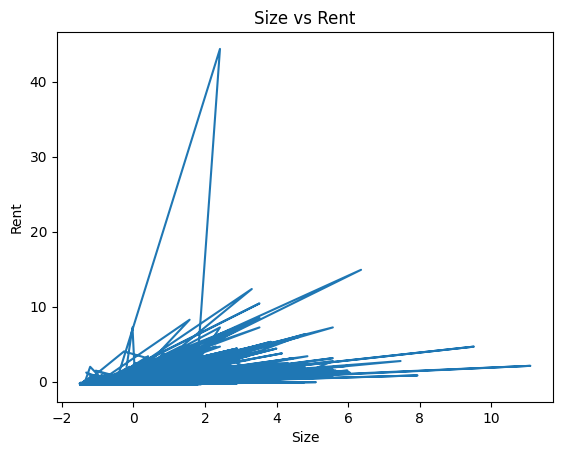

In [5]:
plt.plot(house_rents['Size'], house_rents['Rent'])
plt.xlabel('Size')
plt.ylabel('Rent')
plt.title('Size vs Rent')
plt.show()

In [6]:
# I am only going to use the size feature for convinience
X = house_rents['Size'] # divided with 1000 to simply scale it
y = house_rents['Rent']

In [7]:
# Making a basic cost function (RMSE)
def compute_cost(X, y, b, w):
    m = len(y)
    f = w * X + b
    cost = ((1/(2*m)) * np.sum(np.square(f - y) ** 0.5))
    return cost

In [8]:
# Making a simple function for theta
def theta(X, y, b, w):
  theta_b = 0
  theta_w = 0
  for x, y in zip(X, y):
    f = w * x + b
    theta_b += np.sign(f - y)
    theta_w += np.sign(f - y) * x
  theta_b /= len(X)
  theta_w /= len(X)
  return theta_b, theta_w

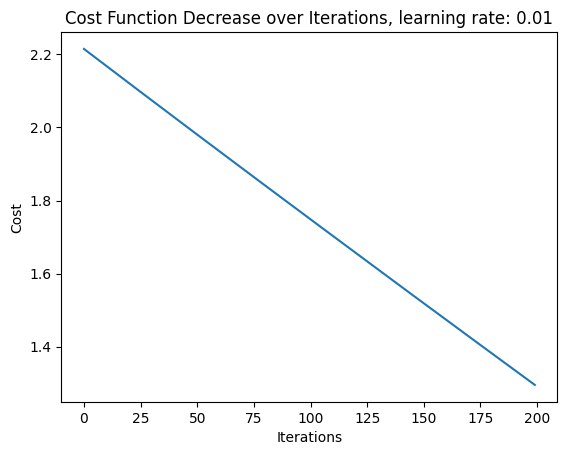

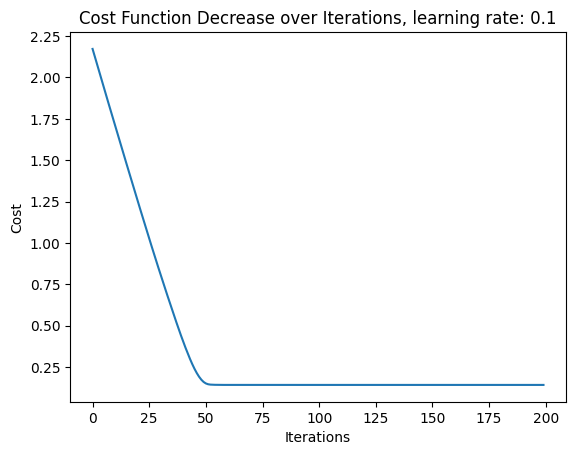

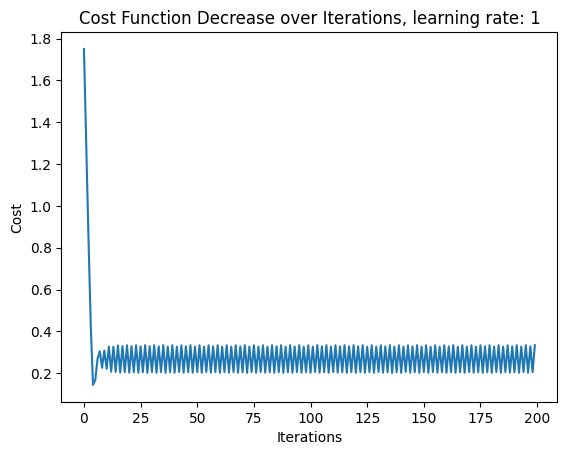

In [12]:
# Making a for loop so that I don't have to copy paste the same code twice.
for i in [0.01, 0.1, 1]:
    # Gradient descent algorithm
    cost_history = np.zeros(200)
    b = 4.33
    w = -0.85
    learning_rate = i
    
    for k in range(200):
        theta_b, theta_w = theta(X, y, b, w)
        b = b - learning_rate * theta_b
        w = w - learning_rate * theta_w

        cost = compute_cost(X, y, b, w)
        cost_history[k] = cost

    # Plotting the cost history
    plt.plot(cost_history)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title(f'Cost Function Decrease over Iterations, learning rate: {i}')
    plt.show()

In [13]:
# A basic function to adjust the learning rate (it multiplies because even when the lr was 1 it was still too small)
def adaptive_learning_rate(initial_lr, iteration, decay_rate):
    return initial_lr / (1 + grow_rate * iteration)

Convergence reached at iteration 48
highest learning rate reached: 0.02079002079002079


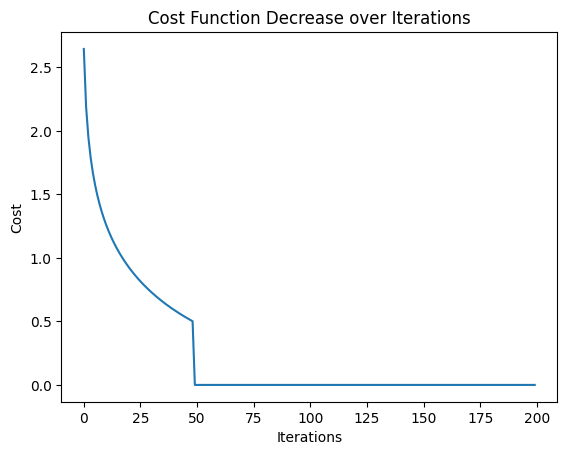

In [14]:
cost_history = np.zeros(200)
b = 4.33
w = -0.85
initial_lr = 10
grow_rate = 10
convergence_threshold = 0.01

for i in range(200):
    # Gradient descent algorithm
    theta_b, theta_w = theta(X, y, b, w)
    lr = adaptive_learning_rate(initial_lr, i, grow_rate)
    b = b - lr * theta_b
    w = w - lr * theta_w

    cost = compute_cost(X, y, b, w)
    cost_history[i] = cost

    if i > 2 and abs(cost_history[i-1] - cost) < convergence_threshold:
        print(f"Convergence reached at iteration {i}")
        break

print(f'highest learning rate reached: {lr}')

# Plotting the cost history
plt.plot(cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Decrease over Iterations')
plt.show()

# Discussion
Overall, for the sake of simplicity, I employed only one feature for the gradient descent algorithm. However, as there are multiple factors influencing rent prices, this constitutes a non-linear regression problem. This complexity makes it challenging to visualize gradient descent adequately. Additionally, due to the significant differences in magnitude between rent price and the size of the property, scaling is necessary. I managed to apply a basic scaling method without utilizing any libraries or developing a complex scaling function myself. But even than I couldn't really scale it well resulting in a really strange learning rate.

Furthermore, it is evident that the learning rates of 0.01, 0.1, and 1 are somewhat inadequate for the model to converge effectively and when I try to converge them before it converges the kernel always dies resulting in it never converging. In experimenting with an adaptive learning rate, I attempted to fine-tune it; however, devising a fully automated process for its adjustment proved difficult. Consequently, I established a partially automated method of adjustment. Through this approach, it was observed that convergence occurred within 90 iterations when implementing the maximum learning rate of 9010, although this rate seems unusually high and suggests a potential anomaly in the algorithm or data that requires further investigation.

# References
Banerjee, P. (2020, April 18). Extensive Analysis - EDA + FE + Modelling [Kaggle notebook]. Kaggle. 
    https://www.kaggle.com/code/prashant111/extensive-analysis-eda-fe-modelling
- I looked at this notebook to get a rough idea about what I can for EDA

Google DeepMind (2022, Feb 22). educational [GitHub repository]. GitHub. https://github.com/google-deepmind/educational/tree/master.

- I looked at this notebook to get a rough idea about what I can for gradient descent.

OpenAI. (2024). ChatGPT [Software]. Available from https://openai.com/

- I used ChatGPT to find the names of some functions in scikit-learn as well as to correct my spelling mistakes in the discussion parts.